# Eigenface

This notebook implements a classic facial recognition technique first identitfied by Sirovich and Kirby (1987). The general idea is to find the principal components of the training set, project both the training data and the image to classify onto the lower dimensional subspace and do a nearest neighbour search in this lower dimensional subspace. This method is based on Principal Component Analysis (PCA), a method for dimensionality reduction that is over 100 years old but is still relevant today.

The training data is taken from the Yale Face A dataset which consists of 135 training images and 10 test images (note this is tiny by today's standards). Just for fun we will augment the training data with some images of me!

In [1]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eigh
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import math
my_face_path = 'Yale-FaceA/myset'

This is some helper code to plot images side by side.

In [2]:
def plot_side_by_side(images, titles, rows=1, cmap='gray', figsize=(8, 4)):
    """Helper function to plot images side by side"""
    fig, axes = plt.subplots(rows, math.ceil(len(images)/rows), figsize=figsize)
    ax = axes.ravel()
    for index, image in enumerate(images):
        ax[index].imshow(image, cmap=cmap)
        ax[index].set_title(titles[index])
    fig.tight_layout()
    plt.show()

First we need to load some data, the following function loads data from the training set into a matrix.

In [3]:
def load_training_set(path, include_my_faces=False):
    """
    Loads the training set into a large data matrix
    :param path: The path to the training set
    :param include_my_faces: Set to True to load in my faces, False otherwise
    :return: A matrix where the columns are the flattened facial images from the training set
    """
    file_names = [f for f in listdir(path) if isfile(join(path, f))]
    images = []
    for file_name in file_names:
        image = plt.imread(f'{path}/{file_name}')
        height, width = image.shape
        images.append(image.flatten())

    if include_my_faces:
        extra_files = [f for f in listdir(my_face_path) if isfile(join(my_face_path, f))]
        for file_name in extra_files:
            image = plt.imread(f'{my_face_path}/{file_name}')
            image = rgb2gray(image)
            height, width = image.shape
            images.append(image.flatten())

    data = np.stack(images, axis=1)
    return data, height, width

Next we need to find the eigenfaces from the training data. This is done by finding the eigenvector of the data covariance matrix. Instead compute the covariance of A.T @ A as this is much smaller and the result is the same.

In [4]:
def get_eigen_faces(data, height, width, k=10, plot_eigen_faces=True):
    """
    Gets the eigen faces (and the mean face).
    :param data: The data matrix
    :param height: The height of the images
    :param width: The width of the images
    :param k: The number of eigen faces
    :return: The eigen faces and the mean face
    """
    # get the mean of data
    mean = np.mean(data, axis=1)
    # to be consistent with notation
    A = (data.T - mean).T
    # compute L = A^T A
    L = A.T @ A
    # compute eigenvalues, eigenvectors of the covariance matrix of A @ A^T 
    w, v = eigh(np.cov(L))
    # get the k largest eigen values & vectors, how to choose k?
    sorted_list = sorted(zip(w,v), key=lambda item: item[0])
    top_k = sorted_list[-k:]
    eigen_faces = []
    # compute eigen vectors of the original covariance matrix s.t. u_i = A * q_i
    for i in range(k):
        l_eigen_vector = top_k[i][1]
        eigen_face = A @ l_eigen_vector
        eigen_faces.append(eigen_face)
        
    images, titles = [], []
    if plot_eigen_faces:
        for index, face in enumerate(eigen_faces):
            images.append(face.reshape(height, width))
            titles.append(f'Eigenface {index}')

        plot_side_by_side(images=images, titles=titles, rows=2)

    return eigen_faces, mean

The following code performs the classification. The steps a re as follows:
1. Project the dataset into the eigen space (first subtract the mean). 
2. Do the same thing to the input image (subtract the mean then project into the eigenspace)
3. Perform a nearest neighbour search

In [5]:
def classify(input_face, mean_face, eigen_faces, data):
    """
    Shows the 3 nearest neighbours for a face
    :param input_face: The input face
    :param mean_face: The means face
    :param eigen_faces: The eigen faces
    :param data: The training set
    """
    eigen_faces= np.array(eigen_faces)
    # flatten the input image
    image = input_face.flatten()
    # subtract the mean
    image = image - mean_face
    height, width = input_face.shape
    # project the images into the reduced space
    dataset_reduced = eigen_faces @ (data.T - mean_face).T
    # project the input into the reduced space
    omega = eigen_faces @ image
    # get the 3 nearest neighbours
    sorted_index = np.argsort(np.sum((dataset_reduced.T - omega)**2, axis=1))
    images = [input_face]
    for i in range(3):
        closest_image = data[:, sorted_index[i]].reshape(height, width)
        images.append(closest_image)

    plot_side_by_side(images=images, titles=['Original', 'Top 1', 'Top 2', 'Top 3'], rows=1)

Lets see what the eigenfaces look like.

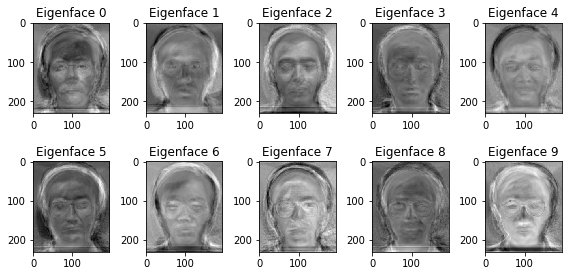

In [6]:
data, height, width = load_training_set('Yale-FaceA/trainingset')
eigen_faces, mean = get_eigen_faces(data=data, height=height, width=width)

Just for fun, let's see which face is the closest face to my own face.

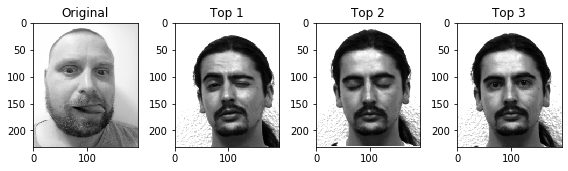

In [7]:
classify_me = rgb2gray(plt.imread('Yale-FaceA/testset/315.jpg'))
classify(classify_me, mean, eigen_faces, data)

Interesting! No let's included my facial images into the training set and see what happens:

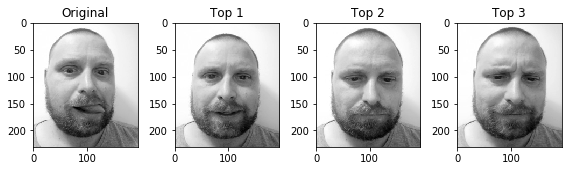

In [9]:
data, height, width = load_training_set('Yale-FaceA/trainingset', include_my_faces=True)
eigen_faces, mean = get_eigen_faces(data=data, height=height, width=width, plot_eigen_faces=False)
classify_me = rgb2gray(plt.imread('Yale-FaceA/testset/315.jpg'))
classify(classify_me, mean, eigen_faces, data)

Why does it matter:
- While deep learning provides state of the art performance on many image classification tasks, it requires a large amount of training data. This technique can be used for classifcation of data when training sets are relatively small
- Generally speaking dimensionality reduction can be very useful when dealing with high dimensional data